Project SHCT

Authors: Curumi Klejsi, Querzè Lorenzo  
Spring semester 2025

In [440]:
#import os
#os.chdir("/content/SHCT")
#import sys
#sys.path.append("/content/SHCT")
from pylab import *
import numpy as np
import Fluid_CP as FCP #calculation of  thermodynamic states
from scipy.optimize import minimize, NonlinearConstraint, Bounds
from scipy.integrate import odeint
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import pandas as pd
from CompressorModel import recip_comp_SP   
import plotDiag_Th_Ts as Diag #plot Th diagram with heat sink and heat source 
import math as _m

In [251]:
# PARAMETERS: 

working_time = 43200 # s, 12 hours in seconds

# Pasta

T_pasta_in = 7 # °C, initial pasta temperature 
T_pasta_fin = 85 # °C, final pasta temperature
m_pasta = 2 # kg, total kg of pasta
m_pasta_basket = 0.5 # kg of pasta per basket
t_break = 300 # s, break time in between batches
t_cook = 420 # s, cooking time for the pasta
R_h2o_pasta = 15 # K/kW, thermal resistance between pasta and water
cp_pasta = 3.5 # kJ/kg K, heat capacity of pasta

# H2O (sink)

T_sink_in = 20 # °C, initial water temperature in the morning
T_min_h2o = 85 # °C, minimum water temperature during operation
T_max_h2o = 93 # °C, maximum water temperature during operation
R_h2o_env = 30 # K/kW, thermal resistance between environment and water
cp_h2o = 4.18 # kJ/kg K, heat capacity of water
rho = 1/FCP.state(['T','p'],[T_max_h2o,1],fluid='water',Eh='CBar')['v'] # kg/m^3, density of water

# Air (source)

T_source = 20 # °C, heat source temperature, constant in cross-flow configuration

# Geometry of the pasta cooker:

h = 0.20 # m
w = 0.27 # m
l = 0.47 # m
V = h*w*l

# Heat duty to heat up the water from 85 to 93°C:

# Assumptions during modeling: 
# - 0D problem: no temperature gradient inside h2o and pasta
# - constant properties for water and pasta ---> therefore, thermal resistances and cps of pasta and water are constant

# Heat pump design:
# subcritical heat pump process
# techical constraints: superheating, subcooling, optimal COP, pinch points are respected...

TASK 1: simulate pasta cooking step

In [252]:
# REQUIRED THERMAL ENERGY INPUT TO COOK THE PASTA

#Q = m_pasta*cp_pasta*(T_pasta_fin - T_pasta_in)
#print('The required thermal energy input to cook pasta is: ', Q, ' kJ')
#Q_dot = Q/t_cook
#print('The required thermal power input to cook pasta is: ', Q_dot, ' kW')

Minimum heat-pump power  Q* = 5.03 kW


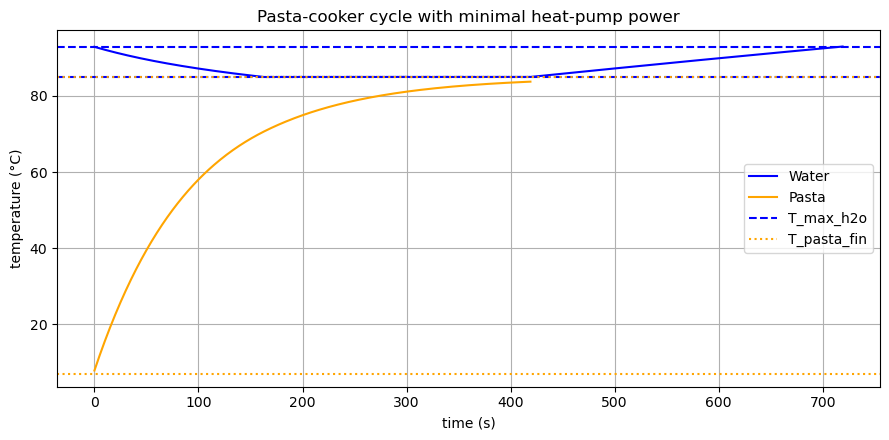

simulating 3 full cycles (0.6 h)


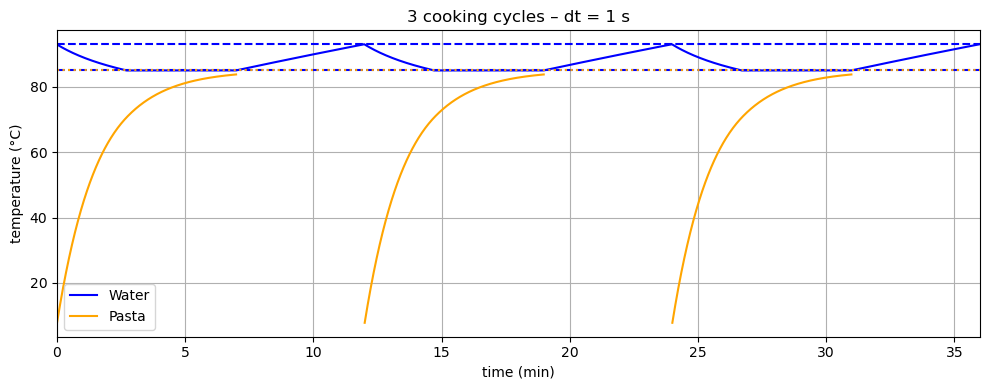

In [253]:
# Derived capacities
C_w = rho * V * cp_h2o          # kJ K⁻¹
C_p = m_pasta * cp_pasta        # kJ K⁻¹

# Integration set-up
dt       = 1.0                                  # s
steps_c  = int(t_cook  / dt)
steps_br = int(t_break / dt)

# ────────────────────────────────────────────────────────────────────────────
# Helper functions
# ────────────────────────────────────────────────────────────────────────────
def run_cycle(Q_hp):
    """Return Tp_end, Tw_after_break for a given pump power (kW)."""
    T_w = T_max_h2o
    T_p = T_pasta_in

    # ―― 7-min cooking phase ―――――――――――――――――――――――――――――――――――――――――
    for _ in range(steps_c):
        pump_on = T_w < T_min_h2o
        Q = Q_hp if pump_on else 0.0
        q_wp = (T_w - T_p) / R_h2o_pasta
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q - q_wp - q_wa) / C_w
        T_p += dt *  q_wp / C_p

    # ―― 5-min reheating / idle phase (pump forced ON) ――――――――――――――――
    for _ in range(steps_br):
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q_hp - q_wa) / C_w       # pasta is out

    return T_p, T_w


def residual(Q_hp):
    """Positive → requirements not met."""
    Tp_end, Tw_break = run_cycle(Q_hp)
    return max(Tp_end - T_pasta_fin,     # pasta too hot?
               T_max_h2o - Tw_break)     # bath still too cold?


# ────────────────────────────────────────────────────────────────────────────
# Find the minimum heat-pump power (kW)
# ────────────────────────────────────────────────────────────────────────────
Q_lo, Q_hi = 0.1, 20.0            # initial bracket
while residual(Q_hi) > 0:         # enlarge until feasible
    Q_hi *= 1.5

Q_star = bisect(residual, Q_lo, Q_hi, xtol=1e-3)
print(f"Minimum heat-pump power  Q* = {Q_star:.2f} kW")

# ────────────────────────────────────────────────────────────────────────────
# Trajectory for plotting
# ────────────────────────────────────────────────────────────────────────────
T_w_hist, T_p_hist = [], []
T_w, T_p = T_max_h2o, T_pasta_in

# 7-min cook
for _ in range(steps_c):
    pump_on = T_w < T_min_h2o
    Q = Q_star if pump_on else 0.0
    q_wp = (T_w - T_p) / R_h2o_pasta
    q_wa = (T_w - T_source) / R_h2o_env
    T_w += dt * (Q - q_wp - q_wa) / C_w
    T_p += dt *  q_wp / C_p
    T_w_hist.append(T_w)
    T_p_hist.append(T_p)

# 5-min break (pump ON)
for _ in range(steps_br):
    q_wa = (T_w - T_source) / R_h2o_env
    T_w += dt * (Q_star - q_wa) / C_w
    T_w_hist.append(T_w)
    T_p_hist.append(np.nan)       # pasta removed

# ────────────────────────────────────────────────────────────────────────────
# Plot
# ────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(9, 4.5))
plt.plot(T_w_hist, label='Water', color='blue')
plt.plot(T_p_hist, label='Pasta', color='orange')
plt.axhline(T_max_h2o,  ls='--', color='blue',   label='T_max_h2o')
plt.axhline(T_min_h2o,  ls='--', color='blue')
plt.axhline(T_pasta_fin, ls=':', color='orange', label='T_pasta_fin')
plt.axhline(T_pasta_in,  ls=':', color='orange')
plt.xlabel('time (s)')
plt.ylabel('temperature (°C)')
plt.title('Pasta-cooker cycle with minimal heat-pump power')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 1. helper that returns the TW & TP trajectories for ONE cycle
#    (identical maths, but we now also return the whole trace)
# --------------------------------------------------------------------------
def one_cycle(Q_hp, T_w0):
    """Run a cook+break cycle starting at water temp T_w0.
       Returns      Tw_trace, Tp_trace, T_w_end
    """
    Tw, Tp = T_w0, T_pasta_in
    Tw_hist, Tp_hist = [], []

    # ➊ cook – pump ON only when Tw < 85 °C
    for _ in range(steps_c):
        pump_on = Tw < T_min_h2o
        Q = Q_hp if pump_on else 0.0
        q_wp = (Tw - Tp) / R_h2o_pasta
        q_wa = (Tw - T_source) / R_h2o_env
        Tw  += dt * (Q - q_wp - q_wa) / C_w
        Tp  += dt *  q_wp / C_p
        Tw_hist.append(Tw)
        Tp_hist.append(Tp)

    # ➋ break – pasta out, pump forced ON
    for _ in range(steps_br):
        q_wa = (Tw - T_source) / R_h2o_env
        Tw  += dt * (Q_hp - q_wa) / C_w
        Tw_hist.append(Tw)
        Tp_hist.append(np.nan)          # pasta absent

    return Tw_hist, Tp_hist, Tw        # final Tw is start of next cycle


# --------------------------------------------------------------------------
# 2. how many cycles in the 12-hour shift?
# --------------------------------------------------------------------------
t_cycle = t_cook + t_break
n_cycles = int(working_time / t_cycle)
n_cycles = 3
print(f"simulating {n_cycles} full cycles ({n_cycles*(t_cook+t_break)/3600:.1f} h)")

# --------------------------------------------------------------------------
# 3. simulate the whole day
# --------------------------------------------------------------------------
Q_star   = Q_star        # ← reuse the optimal power you already found
Tw_all, Tp_all           = [], []
Tw_start                  = T_max_h2o

for k in range(n_cycles):
    Tw_tr, Tp_tr, Tw_start = one_cycle(Q_star, Tw_start)
    Tw_all.extend(Tw_tr)
    Tp_all.extend(Tp_tr)

# build a matching time axis (seconds)
t_all = np.arange(len(Tw_all)) * dt

# --------------------------------------------------------------------------
# 4. plot
# --------------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(t_all/60, Tw_all, label='Water', color='blue')
plt.plot(t_all/60, Tp_all, label='Pasta', color='orange')
plt.axhline(T_max_h2o,  ls='--', color='blue')
plt.axhline(T_min_h2o,  ls='--', color='blue')
plt.axhline(T_pasta_fin, ls=':', color='orange')
plt.xlabel('time (min)')
plt.ylabel('temperature (°C)')
plt.title(f'{n_cycles} cooking cycles – dt = {dt:.0f} s')
plt.xlim(0, n_cycles*(t_cook+t_break)/60)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [254]:
# def model(y,t,Q):
#     T_h2o, T_pasta = y
#     Q_dot_env = (T_h2o - T_source) / R_h2o_env
#     Q_dot_pasta = (T_h2o - T_pasta) / R_h2o_pasta
#     if Q > 0:        
#         dT_h2o_dt = (- Q_dot_pasta + Q) / (V * rho * cp_h2o) # - Q_dot_env - Q_dot_pasta
#     else:
#         dT_h2o_dt = (- Q_dot_env - Q_dot_pasta) / (V * rho * cp_h2o)
#     dT_pasta_dt = (Q_dot_pasta) / (m_pasta * cp_pasta)

#     return [dT_h2o_dt, dT_pasta_dt]

In [255]:
# # Simulation setup

# dt = 1
# t_sim = np.arange(0, t_cook+dt, dt)
# state = [T_max_h2o, T_pasta_in]  # [T_h2o, T_pasta]
# T_h2o = [state[0]]
# T_pasta = [state[1]]
# Q_track = [0]
# heat_pump = "off"
# Q=0

# # Time loop

# for i in range(1, len(t_sim)):
    
#     Tprev = state[0]

#     # --- Controller Logic ---
#     if Tprev <= T_min_h2o:
#         if heat_pump == "off":
#             heat_pump = "on"
#             Q = Q_h2o        
    
#     elif Tprev >= T_max_h2o:
#         if heat_pump == "on":
#             heat_pump = "off"
#             Q = 0       
    
#     elif T_min_h2o < Tprev < T_max_h2o:
#         if heat_pump == "on":
#             Q = Q_h2o
#         else:
#             Q = 0
    
#     # Integrate one step
#     state_next = odeint(model, state, [0, dt], args=(Q,))
#     state = state_next[-1]  # update current state

#     # Store
#     T_h2o.append(state[0])
#     T_pasta.append(state[1])
#     Q_track.append(Q)
# plt.plot(t_sim, T_h2o, label='Water', color='blue')
# plt.plot(t_sim, T_pasta, label='Pasta', color='orange')
# plt.axhline(T_max_h2o)
# plt.axhline(T_min_h2o)
# plt.xlabel('Time [s]')
# plt.ylabel('Temperature [°C]')
# plt.legend()
# plt.grid(True)
# plt.title("Pasta cooking with heat pump on/off control")
# plt.show()
# #print(T_h2o)
# #print(T_pasta)
# plt.plot(t_sim, Q_track)

In [256]:
# def h2o_energy_balance(x):
#     T_in, T_fin = x
#     rho = 1/FCP.state(['T','p'],[T_in,1],fluid='water',Eh='CBar')['v']
#     T_water = np.linspace(T_in, T_fin, t_cook)
#     T_pasta = np.linspace(T_pasta_in, T_pasta_fin, t_cook)
#     Q = 0
#     for t in range(0,t_cook):
#         Q = Q + (T_water[t]-T_source)/R_h2o_env + (T_water[t]-T_pasta[t])/R_h2o_pasta
#     return np.abs(rho*cp_h2o*V*(T_water[0] - T_water[-1]) - Q)

# def h2o_constraint(x):
#     T_in, T_fin = x
#     return T_in - T_fin

In [257]:
# t = linspace(0,t_cook, t_cook+1)
# print(t)

In [258]:
# NC1 = NonlinearConstraint(h2o_constraint, 0, np.inf)
# bounds = [(85,93),(85,93)]
# x0 = [91,87]
# res = minimize(h2o_energy_balance, x0, method='SLSQP', bounds=bounds, constraints=[NC1])
# print(res.x)
# print(res.fun)

In [259]:
# def h2o_final_temperature(T):
#     rho = 1/FCP.state(['T','p'],[T,1],fluid='water',Eh='CBar')['v']
#     dt = 1 # timestep
#     for i in t:
        

Condenser characteristcs

In [446]:
w = 0.27 # m
l = 0.47 # m
d_out = 6.35e-3
t_tube = 0.83e-3
d_in = d_out - 2*t_tube 
spacing = 2e-3
A_corner = 4 *pi*pi * (d_out/2) * ((d_out+spacing)/2)
L_straight = l - 2*spacing - 2*(spacing/2 + d_out)
A_straight = 2 * pi * (d_out/2) * L_straight
edge = (spacing/2) + d_out
A_edge = 2 * pi * (d_out/2) * edge

n = (w-spacing)/(d_out+spacing) 
A_tot = 2*(A_straight+A_edge) + (n-1)*A_corner + (n-2)*A_straight

L_eff = A_tot / (pi * d_out)

print('Number od tubes: ', n)
print('Total area of tubes: ', A_tot)
print(f"effective straight length = {L_eff:.2f} m")




Number od tubes:  32.09580838323354
Total area of tubes:  0.30552571520994104
effective straight length = 15.32 m


Calcualte resistances 

In [567]:
# Heat transfer coefficients

# The thermal conductivity of 316L stainless steel (SS) seamless tubing, which is covered by ASTM A269
lambda_steel = 16.3 # W/m K,

# air
h_air=300      # W/m² K,

# refrigerant 
h_refVL = 2000 # W/m² K,
h_refV = 200   # W/m² K, 
h_refL = 1000  # W/m² K,

# water
h_h2o = 1000   # W/m² K,
T_sink_in = 20 # °C, initial water temperature in the morning

#  Assumptions for T_ev and T_co
# T_ev = 5  # °C, evaporator temperature
# T_co = 40 # °C, condenser temperature
delta_T_sh = 10 # °C, superheating temperature difference
delta_T_sc = 5 # °C, subcooling temperature difference
fluid="Isobutane" # refrigerant used in the heat pump
Eh="CBar"
pinch = 0.5 # °C, pinch point temperature difference



In [568]:
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h,d):
    R_L_conv=1./(h*pi*d) #mK/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #mK/W
    return R_L_cond

In [569]:
#convective heat transfer inner tube wall
R_L_h_refV=calc_RL_conv(h_refV,d_in)
#convective heat transfer inner tube wall
R_L_h_refVL=calc_RL_conv(h_refVL,d_in)
#conductive heat transfer through wall
R_L_lambda=calc_RL_cond(lambda_steel,t_tube, d_out,d_in)
#convective heat transfer outer tube wall
R_L_h_h2o=calc_RL_conv(h_h2o,d_out)
#liquid refr convective heat transfer outer tube wall
R_L_h_refL=calc_RL_conv(h_refL,d_out)


R_L_co_vl = R_L_h_refVL + R_L_lambda + R_L_h_h2o

R_L_co_v = R_L_h_refV + R_L_lambda + R_L_h_h2o

R_L_co_l = R_L_h_refL + R_L_lambda + R_L_h_h2o


In [570]:
def cycle_states (param):
#state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    T_ev, T_co = param
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat

    #state 3: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    if delta_T_sc>0.:
        state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    else:
        state3=state3_sat

    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    
    D = 35 # mm, diameter of the compressor
    param1 = np.concatenate((param, [delta_T_sh, delta_T_sc, D]))
    # print('param1:',param1)
    eta_is, m_dot = recip_comp_SP(param1, fluid, transcrit=False)

    # print("\nDEBUG --- compressor state:")
    # print("h1 =", state1["h"])
    # print("h2s =", state2s["h"])
    # print("eta_is =", eta_is)
    # print("m_dot =", m_dot)
        

    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    # print("h2 =", h2)
    
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    Q_dot_cond = m_dot * (state2["h"] - state3["h"])
    W_dot_comp = m_dot * (state2["h"] - state1["h"])
    
    print("Q_dot_cond =", Q_dot_cond)
    
    COP     = Q_dot_cond / W_dot_comp

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)
    
    return {"1": state1, "2": state2, "3": state3, "4": state4,
            "T_ev": T_ev, "T_co": T_co,
            "m_dot": m_dot, "η_is": eta_is,
            "Q_cond": Q_dot_cond, "W_comp": W_dot_comp,
            "COP": COP,
            "fluid": fluid}


In [571]:
def pinch_con(states):
    T3, T2 = states["3"]["T"], states["2"]["T"]
    # sink water is assumed single-pass, no temp rise
    delta_T_out  = T3 - T_min_h2o
    delta_T_in   = T2 - T_min_h2o
    delta_T_dew  = states["T_co"] - T_min_h2o
    return np.array([delta_T_in, delta_T_out, delta_T_dew])

In [572]:
def pinch_evap(states):
    T1, T4 = states["1"]["T"], states["4"]["T"]
    delta_T_out = T_source - T1
    delta_T_in  = T_source - T4                 # source side once-through
    return np.array([delta_T_in, delta_T_out])

In [573]:
def objective(param):
    T_ev, T_co = param
    st = cycle_states(param)
    return (st["Q_cond"] - Q_star)**2          # least-squares target

In [574]:
def pinch_wrapper(param):
    """Return every pinch ∆T so we can constrain them ≥ ΔT_MIN."""
    T_ev, T_co = param
    st = cycle_states(param)
    delta_T_co = pinch_con(st)
    delta_T_ev = pinch_evap(st)
    return np.hstack((delta_T_co, delta_T_ev))

In [575]:
# bounds: keep the search in physically sensible region
bnds = Bounds([-20, T_source],      # T_ev
              [ T_min_h2o, 110])      # T_co 

nlc  = NonlinearConstraint(pinch_wrapper,
                           lb=np.full(5, pinch),
                           ub=np.full(5, np.inf))

# initial guess
T_ev = 5   # °C, evaporator temperature
T_co = 85  # °C, condenser temperature

x0   = np.array([T_ev, T_co])  # initial guess (°C)

st = cycle_states(x0)
# print(st)
# Diag.Th(state1,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)
res  = minimize(objective, x0,
                method="SLSQP",
                bounds=bnds,
                constraints=[nlc],
                options={"ftol": 1e-4})

print("Optimal T_ev, T_co  =", res.x)
print("Residual (kW)        =", np.sqrt(res.fun))



Q_dot_cond = 3.593893031649158
Q_dot_cond = 3.593893031649158
Q_dot_cond = 3.5938930426791678
Q_dot_cond = 3.593892970565838
Q_dot_cond = 3.593893031649158
Q_dot_cond = 3.593893031649158
Q_dot_cond = 3.5938930338525195
Q_dot_cond = 3.593893030930529
Q_dot_cond = 3.593893031649158
Q_dot_cond = 3.593893031649158
Q_dot_cond = 3.5938930338525195
Q_dot_cond = 3.593893030930529
Q_dot_cond = 3.388977225125922
Q_dot_cond = 3.388977225125922
Q_dot_cond = 3.388977227256065
Q_dot_cond = 3.38897722440115
Q_dot_cond = 3.388977225125922
Q_dot_cond = 3.388977227256065
Q_dot_cond = 3.38897722440115
Q_dot_cond = 3.4565222403815716
Q_dot_cond = 3.4565222403815716
Q_dot_cond = 3.4565222425369373
Q_dot_cond = 3.4565222396473834
Q_dot_cond = 3.4565222403815716
Q_dot_cond = 3.4565222425369373
Q_dot_cond = 3.4565222396473834
Q_dot_cond = 3.796885877446326
Q_dot_cond = 3.796885877446326
Q_dot_cond = 3.7968858797360796
Q_dot_cond = 3.79688587666508
Q_dot_cond = 3.796885877446326
Q_dot_cond = 3.7968858797360796

Q_dot_cond = 4.00415885588473
COP:  2.2598685709847675


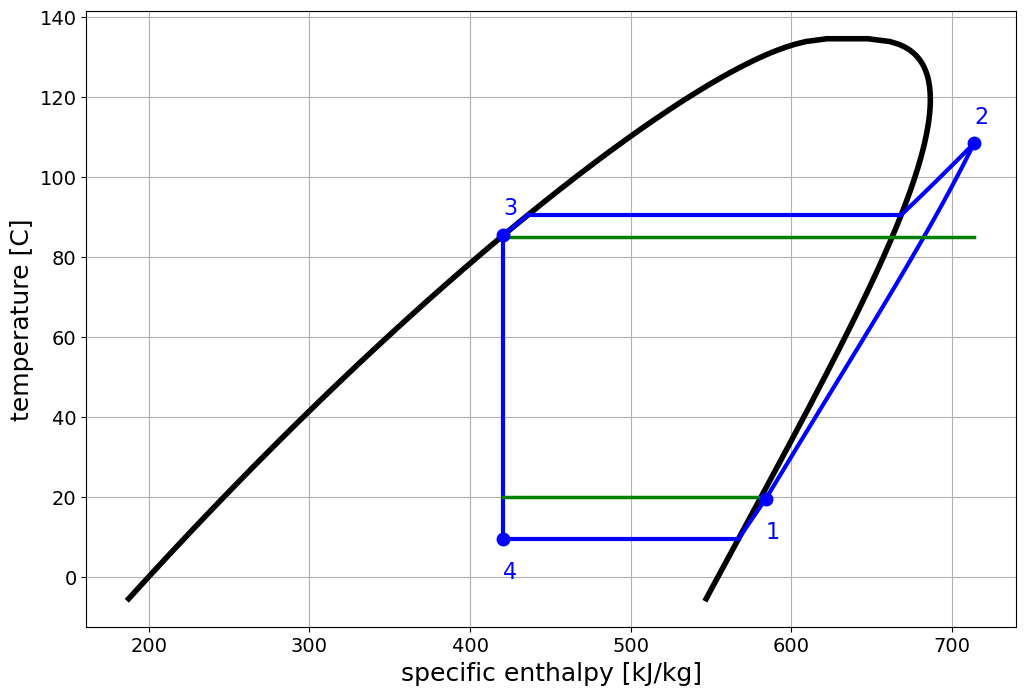

In [576]:
st = cycle_states(res.x)
print("COP: ", st["COP"])
Diag.Th(st["1"],st["2"],st["3"],st["4"],[T_min_h2o,T_min_h2o],[T_source,T_source],fluid,Eh)

# print(st)
# param1 = [T_ev, T_co, delta_T_sh, delta_T_sc, diameter in mm]  # T_ev, T_co, delta_T_sh, delta_T_sc, D
# param1 =[30, 40, 5, 0, 40]
# print('param1:',param1)
# eta_is, m_dot = recip_comp_SP(param1, fluid, transcrit=False)
# print("m_dot (kg/s)       =", m_dot)
# print("η_is               =", eta_is)
# print("fluid              =", fluid)



In [ ]:
T_ev_opt = res.x[0]  # optimal evaporator temperature
T_co_opt = res.x[1]  # optimal condenser temperature
delta_T_vl = T_co_opt - T_min_h2o
T2 = st["2"]["T"]
delta_T_v = (T2 - T_co_opt) / (log((T2-T_min_h2o)/(T_co_opt-T_min_h2o)))

T3_x0=FCP.state(["T","x"],[T_co_opt,1],fluid,Eh)["T"]
# delta_T_l = ()
h3_x1=FCP.state(["T","x"],[T_co_opt,1],fluid,Eh)["h"]
h3_x0=FCP.state(["T","x"],[T_co_opt,0],fluid,Eh)["h"]

Q_dot_l = st["m_dot"] * (h3_x0 - st["3"]["h"]) # kW, heat transfer in the condenser liquid line
Q_dot_vl = st["m_dot"] * (h3_x1 - h3_x0) # kW, heat transfer in the condenser vapor/liquid line
Q_dot_v = st["m_dot"] * (st["2"]["h"] - h3_x1) # kW, heat transfer in the condenser vapor line
Q_dot_tot = Q_dot_vl + Q_dot_v

# print(Q_dot_l)
# print(delta_T_vl)

# print(R_L_co_v)
# print(R_L_co_vl)
# print(Q_dot_v)

L_vl = (R_L_co_vl * Q_dot_vl *1000) / delta_T_vl
L_v = (R_L_co_v * Q_dot_v *1000) / delta_T_v
# L_l = (R_L_co_l * Q_dot_l *1000) / delta_T_l
print(L_v)
print(L_vl)


0.20941731268750832
5.5
19.68149162565373
50.22717791412131
